We solve the PDE
$$u_t + au_x = \nu u_{xx}$$
on $\mathbb{R}$ with the initial condition $u(x,0) = \sin(2\pi x)$. We will use Scheme (a) from Problem 1:
$$\frac{U_j^{n+1} - U_j^n}{\Delta t} + a\frac{U_{j+1}^{n+1} - U_{j-1}^{n+1}}{2\Delta x} = \nu \frac{U_{j+1}^{n+1} - 2U_j^{n+1} + U_{j-1}^{n+1}}{\Delta x^2}$$
We can write this scheme as $AU^{n+1} = BU^n$, where
$$A = \begin{bmatrix} 
    (1 + 2r) & (s - r) & \cdots & \cdots & \cdots & -(s + r) & 0 \\
    -(s + r) & (1 + 2r) & (s - r) & \cdots & \cdots & \cdots & 0 \\
    0 & -(s + r) & (1 + 2r) & (s - r) & \cdots & \cdots & 0 \\
    0 & \cdots & -(s + r) & (1 + 2r) & (s - r) & \cdots & 0 \\
    0 & \cdots & \cdots &  -(s + r) & (1 + 2r) & (s - r)  & 0 \\
    0 & \cdots & \cdots & \cdots & -(s + r) & (1 + 2r) & (s - r) \\
    0 & (s - r) & \cdots & \cdots & \cdots & -(s + r) & (1 + 2r)
\end{bmatrix}$$
and
$$B = \begin{bmatrix} 
    (1 - 2r) & (r - s) & \cdots & \cdots & \cdots & (s + r) & 0 \\
    (s + r) & (1 - 2r) & (r - s) & \cdots & \cdots & \cdots & 0 \\
    0 & (s + r) & (1 - 2r) & (r - s) & \cdots & \cdots & 0 \\
    0 & \cdots & (s + r) & (1 - 2r) & (r - s) & \cdots & 0 \\
    0 & \cdots & \cdots &  (s + r) & (1 - 2r) & (r - s)  & 0 \\
    0 & \cdots & \cdots & \cdots & (s + r) & (1 - 2r) & (r - s) \\
    0 & (r - s) & \cdots & \cdots & \cdots & (s + r) & (1 - 2r)
\end{bmatrix}$$
with
$$r = \frac{\nu\,\Delta t}{2 \Delta x^2} \quad \text{ and } \quad s = \frac{a\,\Delta t}{4\Delta x}$$
$A$ is sparse and hence not tridiagonal because of the periodicity of our solution, so we cannot solve it optimally. However, $A$ and $B$ do not depend on time, so we can solve this system by computing $A^{-1}B$ once and then iteratively computing
$$U^{n+1} = (A^{-1}B)\, U^n$$

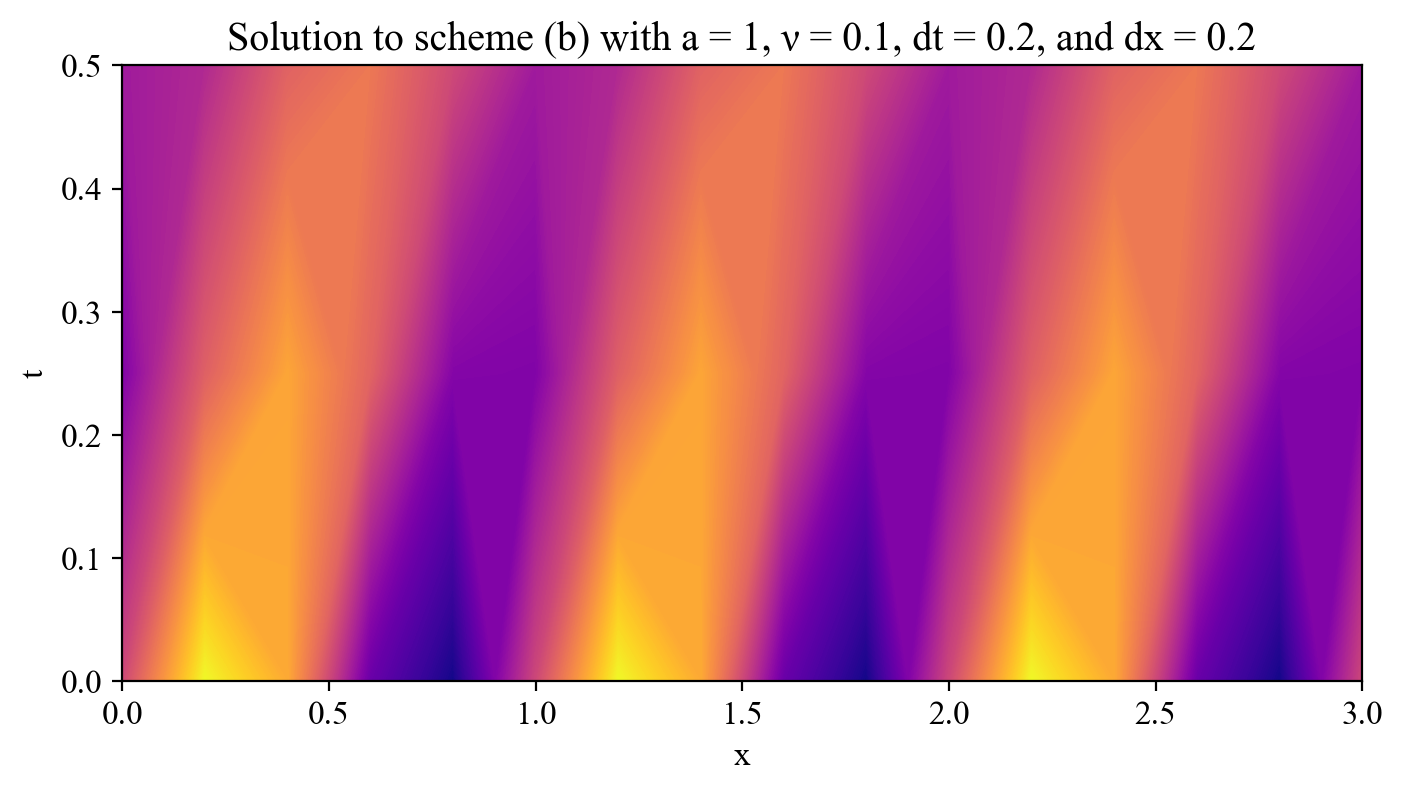

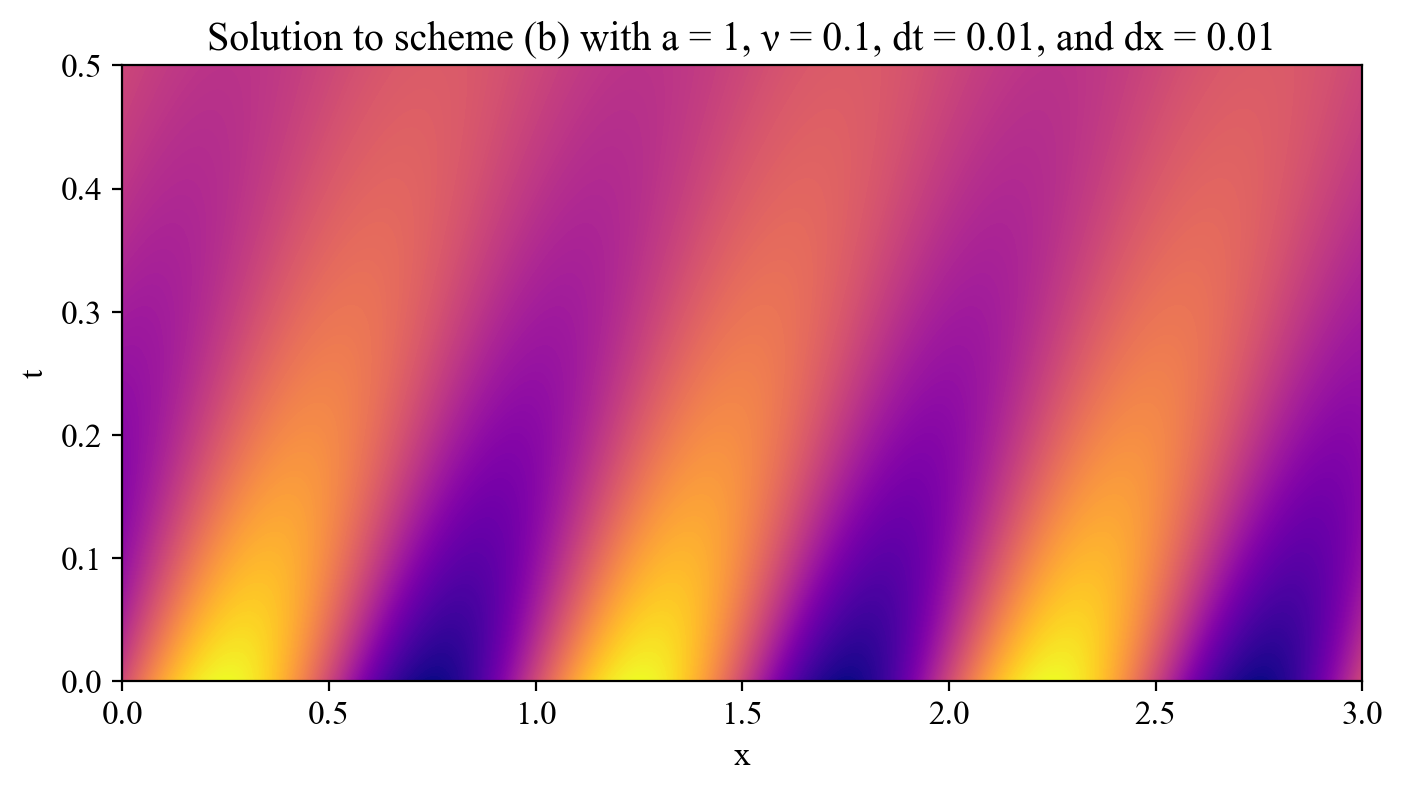

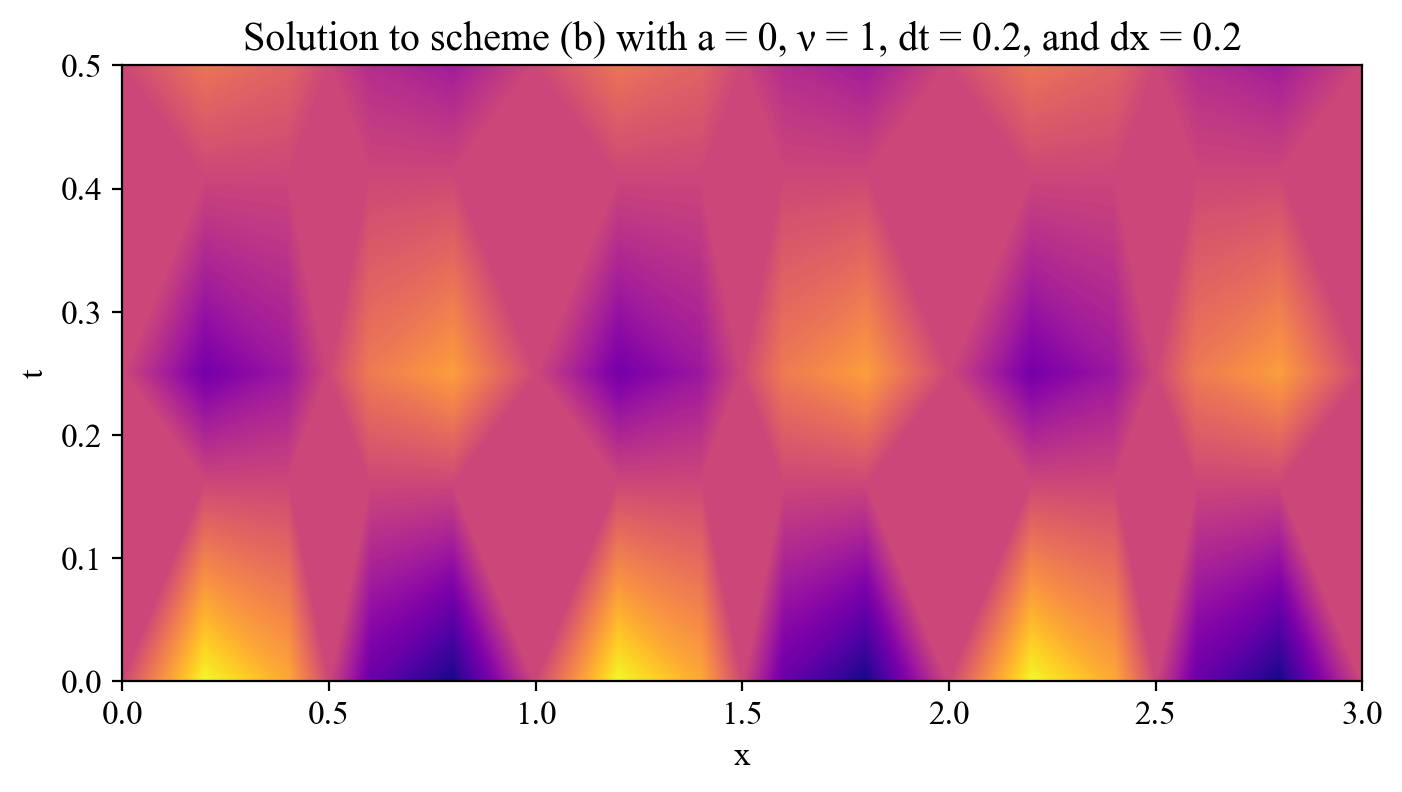

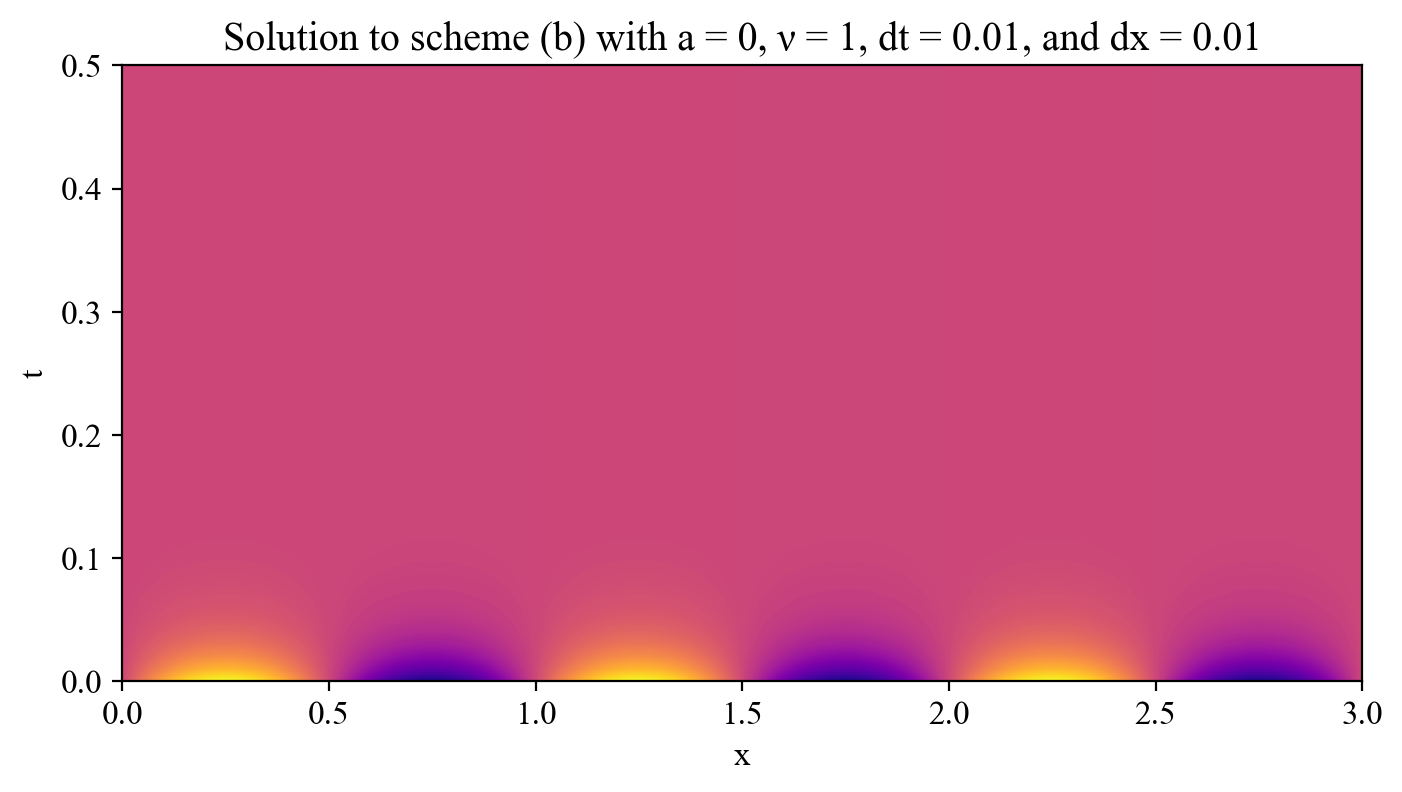

In [12]:
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib import colormaps as cm

def get_rs(dx, dt, a, nu):
    r = (nu * dt) / (2 * math.pow(dx,2))
    s = (a * dt) / (4 * dx)
    return r, s

# Define A and B matrices as above
def get_AB(xarr_len, r, s):
    N = xarr_len - 1
    A = np.zeros((xarr_len, xarr_len))
    B = np.zeros((xarr_len, xarr_len))

    A[0,0] = (1 + 2*r)
    A[0,1] = (s - r)
    A[0,N-1] = (-s - r)
    A[N,1] = (s - r)
    A[N,N-1] = (-s - r)
    A[N,N] = (1 + 2*r)

    B[0,0] = (1 - 2*r)
    B[0,1] = (r - s)
    B[0,N-1] = (s + r)
    B[N,1] = (r - s)
    B[N,N-1] = (s + r)
    B[N,N] = (1 - 2*r)

    for i in range(1,N):
        A[i,i] = (1 + 2*r)
        A[i,i-1] = (-s - r)
        A[i,i+1] = (s - r)

        B[i,i] = (1 - 2*r)
        B[i,i-1] = (s + r)
        B[i,i+1] = (r - s)

    return A, B

# Scheme class holds scheme data and methods
class Scheme:
    def __init__(self, xi, xf, T, dt, dx, a, nu, initial_fun):
        self.xarr_len = int(1 / dx) + 1
        self.xarr = np.linspace(xi, xf, self.xarr_len)
        self.tarr_len = int(T / dt) + 1
        self.tarr = np.linspace(0, T, self.tarr_len)

        self.T = T
        self.dt = dt
        self.dx = dx
        self.a = a
        self.nu = nu

        self.r, self.s = get_rs(self.dx, self.dt, self.a, self.nu)

        self.A, self.B = get_AB(self.xarr_len, self.r, self.s)
        self.initial_fun = initial_fun
    
    def solve(self):
        # Initialize solution matrix
        sol = np.zeros((self.tarr_len, self.xarr_len))
        sol[0,:] = [initial_fun(x) for x in self.xarr]

        A_inv = np.linalg.inv(self.A)

        # Compute U(n+1) = [A^-1 B] U^n until the final time
        for i in range(1, self.tarr_len):
            sol[i,:] = (A_inv @ self.B) @ sol[i-1,:]
        
        self.sol = sol
        return sol
    
    def plot_sol(self, periods):
        plt.rcParams['font.family'] = 'Times New Roman'
        plt.rcParams['font.size'] = 12

        fig = plt.figure(figsize=(8,4), dpi=200)

        # Reshapes xarr and sol to plot multiple periods if desired
        xarr_len = int(1 / dx)*periods + 1
        xarr = np.linspace(xi, xf*periods, xarr_len)
        sol_truncated = self.sol[:, :-1]
        sol = np.concatenate([sol_truncated for i in range(periods)], axis=1)
        sol = np.concatenate((sol, self.sol[:,-1][:, np.newaxis]), axis=1)

        num_levels = 200
        T, X = np.meshgrid(self.tarr, xarr)
        plt.contourf(X, T, np.transpose(sol), levels=num_levels, cmap='plasma')

        plt.xlabel("x")
        plt.ylabel("t")
        titlestr = "Solution to scheme (b) with a = " + str(self.a) + ", ν = " + str(self.nu) + ", dt = " + str(self.dt) + ", and dx = " + str(self.dx) 
        plt.title(titlestr)

        plt.savefig("numerical_solution_a=" + str(self.a) + "_ν=" + str(self.nu) + "_dt=" + str(self.dt) + "_dx=" + str(self.dx) + ".png")


#
#
# ___ Main Function ___        

a = 1
nu = 0.1

xi = 0
xf = 1
T = 0.5

dt = 2e-1
dx = 2e-1

initial_fun = lambda x: math.sin(2 * math.pi * x)

myscheme = Scheme(xi, xf, T, dt, dx, a, nu, initial_fun)
myscheme.solve()
myscheme.plot_sol(3)

dt = 1e-2
dx = 1e-2

myscheme2 = Scheme(xi, xf, T, dt, dx, a, nu, initial_fun)
myscheme2.solve()
myscheme2.plot_sol(3)

a = 0
nu = 1
dt = 2e-1
dx = 2e-1

myscheme2 = Scheme(xi, xf, T, dt, dx, a, nu, initial_fun)
myscheme2.solve()
myscheme2.plot_sol(3)

dt = 1e-2
dx = 1e-2

myscheme2 = Scheme(xi, xf, T, dt, dx, a, nu, initial_fun)
myscheme2.solve()
myscheme2.plot_sol(3)